In [259]:
from pathlib import Path
import math
import torch
import taichi as ti
from tqdm import trange

from torchvtk.datasets import TorchDataset
from torchvtk.utils import make_4d, tex_from_pts, TFGenerator
from torchvtk.rendering import plot_tf

from differender.utils import get_tf, in_circles, get_rand_pos
from differender.volume_raycaster import Raycaster, Mode

import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

In [2]:
def show_im(im):
    fig, axs = plt.subplots(2,3, figsize=(15,10))
    axs[0,0].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs[0,0].set_title('Color')
    axs[0,1].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs[0,1].set_title('Alpha')
    axs[0,2].imshow(im.squeeze()[[4,4,4]].permute(1,2,0).cpu().numpy())
    axs[0,2].set_title('First Hit')
    axs[1,0].imshow(im.squeeze()[[5,5,5]].permute(1,2,0).cpu().numpy())
    axs[1,0].set_title('Max Opacity')
    axs[1,1].imshow(im.squeeze()[[6,6,6]].permute(1,2,0).cpu().numpy())
    axs[1,1].set_title('Max Gradient')
    axs[1,2].imshow(im.squeeze()[[7,7,7]].permute(1,2,0).cpu().numpy())
    axs[1,2].set_title('WYSIWYP')

In [3]:
W, H = 512, 512
TF_RES = 256
SR = 16.0 # Sampling rate
BINS = 51

ds = TorchDataset('/run/media/dome/Data/data/torchvtk/CQ500')
N_VOLUMES = len(ds)
METHOD = Mode.WYSIWYP
# MEHTOD = Mode.MaxGradient
# METHOD = Mode.MaxOpacity
vol = ds[0]['vol']

In [4]:
tfgen = TFGenerator(colors='distinguishable', peakgen_kwargs={
    'max_num_peaks': 3,
    'height_range': (0.02, 0.6),
    'width_range': (0.005, 0.05),
    'use_hist': False
})

In [206]:
ti.reset()

In [208]:
raycaster = Raycaster(vol.shape[-3:], (128,128), TF_RES, 
        sampling_rate=8.0, near=0.1, far=5.0, max_samples=2048, mode=METHOD, ti_kwargs={'device_memory_fraction':0.5})

[Taichi] Starting on arch=cuda


In [209]:
lf = in_circles(4.7)
tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
tf = get_tf('tf1', TF_RES).float().to('cuda')

In [266]:
rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=8.0, mode=Mode.WYSIWYP).squeeze(0)

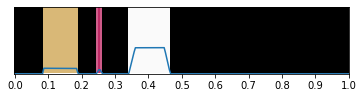

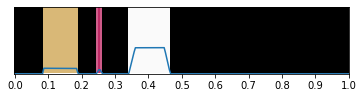

In [212]:
plot_tf(tf)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


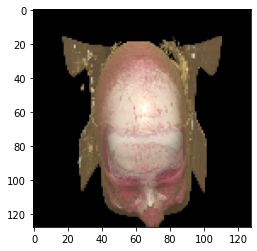

In [213]:
plt.imshow(rgbad[:3].permute(1,2,0))

In [267]:
ray = raycaster.vr.ray.to_torch().permute(1,0)

In [231]:
wys_intervals = ray[2]

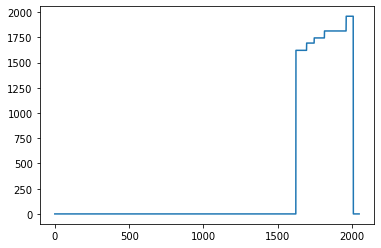

In [269]:
plt.plot(wys_intervals)

In [217]:
raycaster.vr.sample_step_nums.to_torch()[32,32]

tensor(9386, dtype=torch.int32)

In [270]:
op_grad = torch.cat([torch.zeros(1), (ray[1,1:] - ray[1,:-1])], dim=0)
#mida_bs = ray[3]

In [280]:
d_fh = (ray[0] > 0).float().argmax().item()
d_mo = ray[0].argmax().item()
d_mg = op_grad.argmax().item()
d_mida = mida_bs.argmin().item()
CUTOFF = math.floor(d_fh / 100) * 100

CUTOFF, d_fh, d_mo, d_mg, d_mida

(1600, 1622, 1966, 1819, 1818)

In [314]:
wys_interval_borders = torch.unique(wys_intervals)
wys_interval_fromto = torch.stack([wys_interval_borders[:-1], wys_interval_borders[1:]], dim=1)
wys_interval_fromto = torch.cat([wys_interval_fromto, torch.tensor([[wys_interval_borders[-1], ray.size(1)-1]])])[1:]
wys_interval_fromto

tensor([[1622., 1694.],
        [1694., 1745.],
        [1745., 1814.],
        [1814., 1960.],
        [1960., 2047.]])

In [315]:
interval_idx = wys_interval_fromto.long()
wys_op_diffs = ray[1, interval_idx[:,1]] - ray[1, interval_idx[:,0]]
d_wys_idx = wys_op_diffs.argmax()
d_wys = wys_interval_fromto[d_wys_idx, 0]
d_wys_idx, d_wys

(tensor(3), tensor(1814.))

In [272]:
ray[1, d_fh:][ray[1, d_fh:] == 0.0] = ray[1].max()

In [364]:
xticks = [
    (d_fh, 'FirstHit'), 
    (d_mida, '\nMIDA'), 
    (d_mg, '                      MaxGradient'), 
    (d_wys, 'WYSIWYP                '),
    (d_mo, 'MaxOpacity')]
xtickval, xticklab = zip(*xticks)

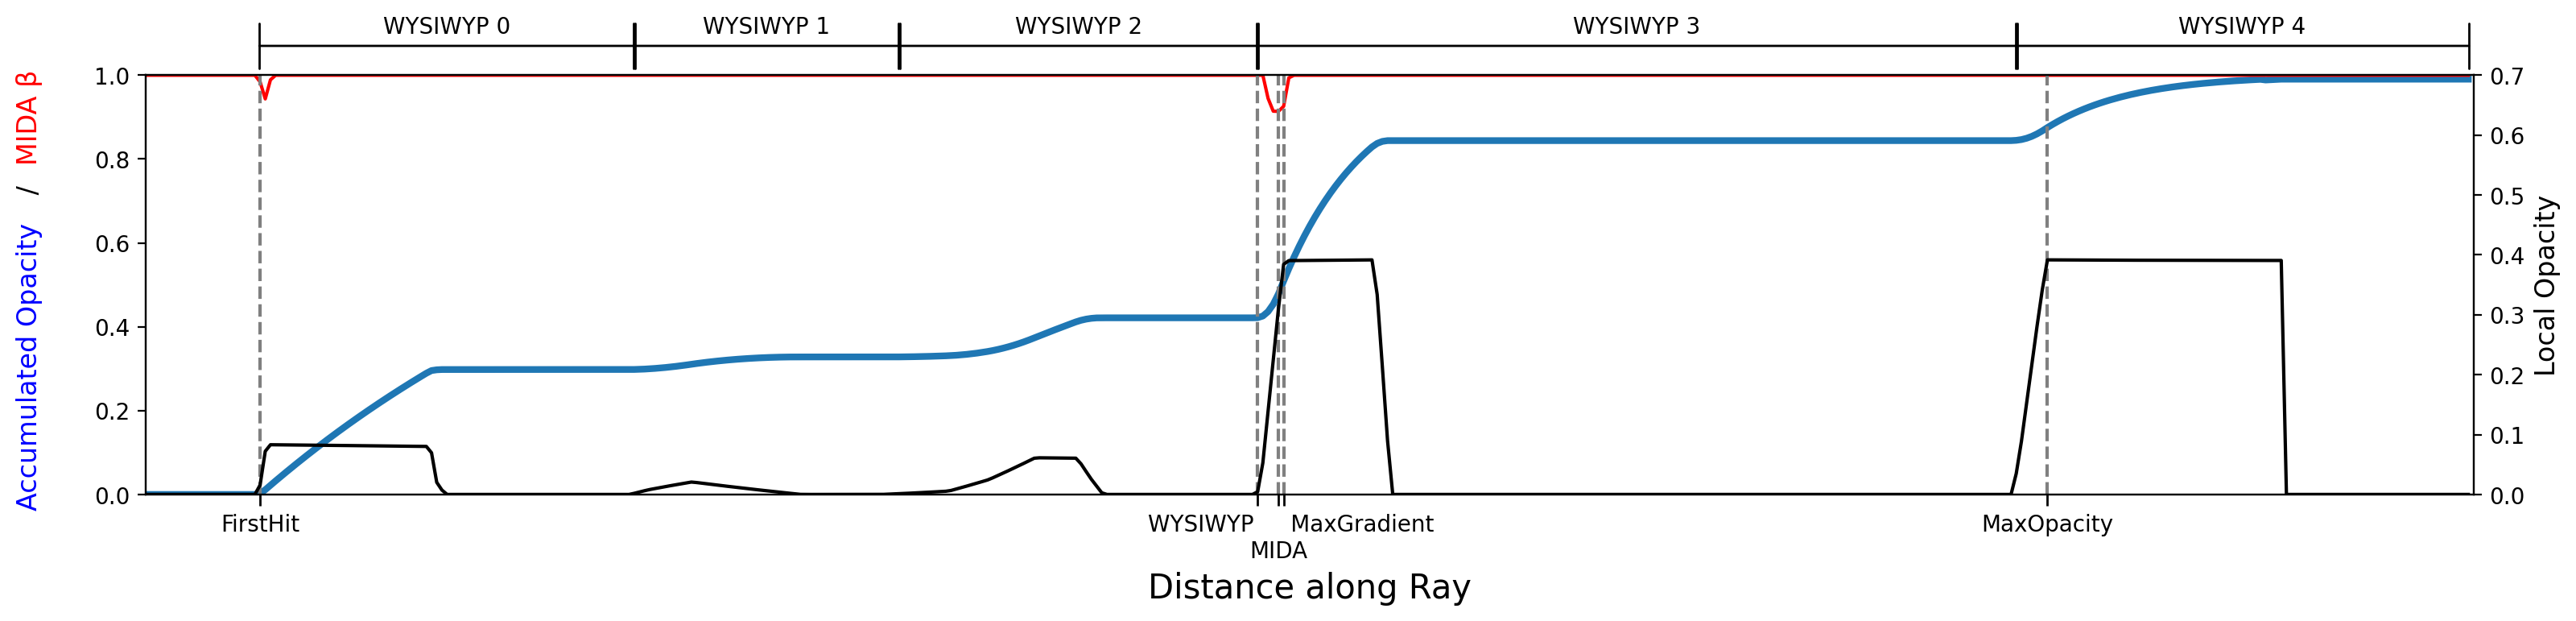

In [365]:
fig, ax = plt.subplots(1,1, figsize=(16, 4), dpi=200, tight_layout=True)

ax.plot(ray[1], label='Accumulated Opacity', linewidth=3)
ax.plot(mida_bs, label='MIDA Beta', color='red')
ax.set_xlabel('Distance along Ray', size=15)

# Left Y Axis
ybox1 = TextArea("MIDA β", textprops=dict(color="r", size=12,rotation=90,ha='left',va='bottom'))
ybox2 = TextArea(" / ",     textprops=dict(color="black", size=12,rotation=90,ha='left',va='bottom'))
ybox3 = TextArea("Accumulated Opacity ", textprops=dict(color="b", size=12,rotation=90,ha='left',va='bottom'))
ybox = VPacker(children=[ybox1, ybox2, ybox3],align="bottom", pad=0, sep=5)

anchored_ybox = AnchoredOffsetbox(loc=8, child=ybox, pad=0., frameon=False, bbox_to_anchor=(-0.05, -0.05), 
                                  bbox_transform=ax.transAxes, borderpad=0.)
ax.add_artist(anchored_ybox)
ax.set_ylim([0.0, 1.0])

# X axis
ax.set_xlim([CUTOFF,ray.size(1)])
ax.tick_params(axis='x', width=1, length=5)
ax.set_xticks(xtickval)
ax.set_xticklabels(xticklab, ha='center', va='top')


# Right Y Axis
ax2 = ax.twinx()
ax2.plot(ray[0], label='Local Opacity', color='black')
ax2.set_ylabel('Local Opacity', color='black', size=12)
ax2.set_ylim([0.0, 0.7])


# Vertical Lines
for v in xtickval:
    ax.axvline(x=v, color='gray', linestyle='dashed')

# WYSIWYP Intervals
for i, ft in enumerate(wys_interval_fromto):
    f, t = ft[0].item(), ft[1].item()
    ax.annotate('', xy=(f-1, 1.07), xycoords='data', xytext=(t+1, 1.07), textcoords='data', arrowprops=dict(arrowstyle='|-|'), annotation_clip=False)

    ax.annotate(f'WYSIWYP {i}', xy=((t+f)/2, 1.1), xycoords='data', annotation_clip=False, ha='center')


